In [1]:
import numpy as np

import astropy.units as u
import astropy.constants as const
import matplotlib.pyplot as plt
import os
from matplotlib.pyplot import axvline
from scipy.interpolate import interp1d

import glob as glob
from scipy.optimize import curve_fit
import time
import string


In [2]:
import sys


from read import *
from recoil_1223 import *

import glob

In [3]:
folder = '../unbinned_Er_pdf_itp'

In [4]:
def generate_accept_inputfile(original_x, original_y, xMin, xMax, yMax):
    rdm_xy = [xMin + ( xMax - xMin )*np.random.uniform() , yMax* np.random.uniform()]
    while(rdm_xy[1]>linear_intp(rdm_xy[0], original_x,  original_y)):
        rdm_xy = [xMin + ( xMax - xMin )*np.random.uniform() , yMax* np.random.uniform()]
    return rdm_xy

In [5]:
unit_pdf = (u.tonne*u.yr*u.keV)**(-1)
unit_Er = u.keV

In [6]:
metallicity = 'high'

In [7]:
glob.glob(os.path.join(folder, '*10000000*'))

['../unbinned_Er_pdf_itp/Er_8B_NR_Argon_NR_Argon_tot_10000000_thrd1keV_high_smear0.1.txt',
 '../unbinned_Er_pdf_itp/Er_8B_NR_Argon_NR_Argon_tot_10000000_thrd1keV_low_smear0.1.txt',
 '../unbinned_Er_pdf_itp/Er_8B_NR_Argon__10000000_thrd1keV.txt',
 '../unbinned_Er_pdf_itp/Er_8B_NR_Xenon__10000000_thrd1keV.txt',
 '../unbinned_Er_pdf_itp/Er_atmNu_CJPL_avg_NR_Argon_NR_Argon_tot_10000000_thrd1keV_smear0.1.txt',
 '../unbinned_Er_pdf_itp/Er_atmNu_CJPL_avg_NR_Argon__10000000_thrd1keV.txt',
 '../unbinned_Er_pdf_itp/Er_atmNu_CJPL_avg_NR_Xenon__10000000_thrd1keV.txt',
 '../unbinned_Er_pdf_itp/Er_atmNu_Kamioka_avg_NR_Argon_NR_Argon_tot_10000000_thrd1keV_smear0.1.txt',
 '../unbinned_Er_pdf_itp/Er_atmNu_Kamioka_avg_NR_Argon__10000000_thrd1keV.txt',
 '../unbinned_Er_pdf_itp/Er_atmNu_Kamioka_avg_NR_Xenon__10000000_thrd1keV.txt',
 '../unbinned_Er_pdf_itp/Er_atmNu_LNGS_avg_NR_Argon_NR_Argon_tot_10000000_thrd1keV_smear0.1.txt',
 '../unbinned_Er_pdf_itp/Er_atmNu_LNGS_avg_NR_Argon__10000000_thrd1keV.txt',
 

# Xenon

NR
 ../real_data_nest/pdf/atmNu_SURF_avg_NR_Xenon_pdf.txt
survival
0.0 percent complete
valueERROR
1.0 percent complete
2.0 percent complete
3.0 percent complete
4.0 percent complete
valueERROR
5.0 percent complete
6.0 percent complete
7.000000000000001 percent complete
8.0 percent complete
9.0 percent complete
valueERROR
10.0 percent complete
11.0 percent complete
valueERROR
valueERROR
valueERROR
12.0 percent complete
valueERROR
13.0 percent complete
valueERROR
valueERROR
valueERROR
14.000000000000002 percent complete
15.0 percent complete
16.0 percent complete
17.0 percent complete
18.0 percent complete
19.0 percent complete
valueERROR
20.0 percent complete
21.0 percent complete
22.0 percent complete
23.0 percent complete
24.0 percent complete
25.0 percent complete
26.0 percent complete
27.0 percent complete
valueERROR
28.000000000000004 percent complete
valueERROR
28.999999999999996 percent complete
30.0 percent complete
31.0 percent complete
32.0 percent complete
33.0 percent compl

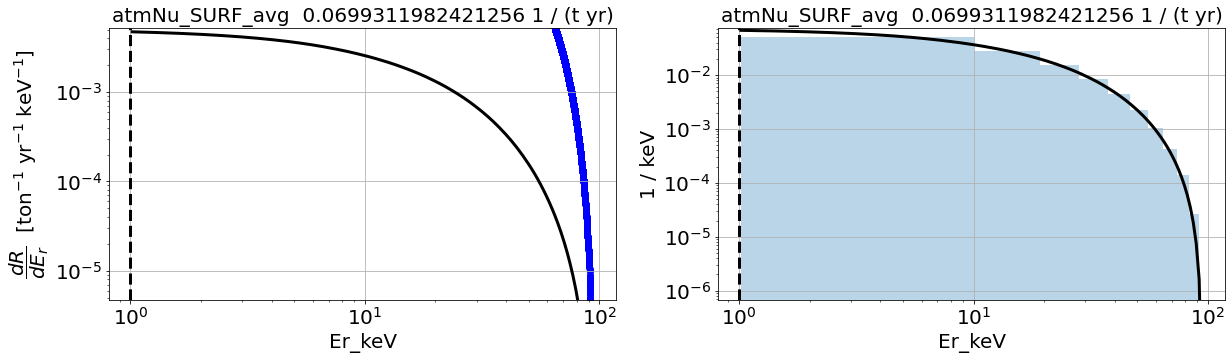

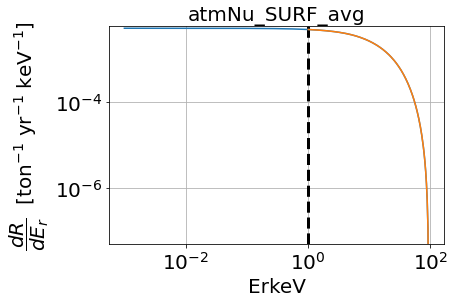

In [9]:
eff_types = ['']#['NR_Xe100_S1S2']
nuclei = 'Xenon'
detectors = ['SURF']#'CJPL','Kamioka', 'LNGS',  'SNOlab', 
E_threshold_keV = 1

pcles = [ 'dsnb']#['pp',  'Be7_384', 'Be7_861', 'pep','CNO']#[ '8B']#, ,  'Kr85', 'nubb', 'Rn222'
#[ 'hep', '8B']## + ['atmNu_'+detector +'_avg' for detector in detectors]#
size = 10000000
write = True
corr = ''#'_smear'
PLOT_THRD = 1e8

for p, pcle in enumerate(pcles):
    
    recoil_type = get_recoil_type(pcle)
    bind = get_Ebind(pcle,recoil_type, True)
    for eff_type in eff_types:
        if size < PLOT_THRD:
            fig2, ax2 = plt.subplots(1, 2, figsize = (10*2, 5))
        
        Er_keV, pdf  = read_pcle_pdf(pcle, nuclei, eff_type, recoil_type = recoil_type, 
                                     metallicity_model = metallicity, ebinding = True, plot = True, corr = corr)
        
        good = [p>0 and E>=E_threshold_keV for p, E in zip(pdf, Er_keV)]
        valid_Er_keV, valid_pdf = Er_keV[good], pdf[good]
        
        valid_cdf = get_cdf(valid_pdf[:-1]*unit_pdf, np.diff(valid_Er_keV)*unit_Er, 'survival')
        norm = max(get_cdf(valid_pdf[:-1]*unit_pdf, np.diff(valid_Er_keV)*unit_Er, ''))

        plt.loglog(valid_Er_keV, valid_pdf)
        f = interp1d(valid_cdf/norm, valid_Er_keV[:-1], bounds_error=True)
        
        j = 0
        accept_x, accept_y = np.zeros(size), np.zeros(size)
        start = time.time()
        while j < size:
            if j % int(size/100) ==0:
                print(j/size*100, 'percent complete')

        
            try:
                cdf_sim = np.random.uniform() 
                keV = f(cdf_sim)
                
            except ValueError:
                print('valueERROR')
                continue
            
            accept_x[j], accept_y[j] = keV, cdf_sim
            j+=1
            #accept_x[s], accept_y[s] = generate_accept_inputfile(valid_Er_keV, valid_pdf, 
            #                                    min(valid_Er_keV), max(valid_Er_keV), max(valid_pdf)+max(valid_pdf)/10)
        print('--------',time.time() - start,'s---------')
        

        ebind = get_Ebind(pcle,recoil_type, True)
        if corr !='' and pcle not in ['Kr85', 'nubb', 'Rn222' ]:
            file_name = 'Er_'+pcle+ebind+recoil_type+'_'+nuclei+'_'+eff_type+'_'+str(
                size)+'_thrd'+str(
                E_threshold_keV)+'keV_'+metallicity+corr+'.txt'
        else:
            file_name = 'Er_'+pcle+ebind+recoil_type+'_'+nuclei+'_'+eff_type+'_'+str(
                size)+'_thrd'+str(
                E_threshold_keV)+'keV'+corr+'.txt'
        print(file_name)
        file= os.path.join(folder,file_name)
        if write:
            write_file_data(file, np.array([accept_x, accept_y]).T, 10, append= False)
        
        norm = max(get_cdf(valid_pdf[:-1]*unit_pdf, np.diff(valid_Er_keV)*unit_Er, ''))
        print(norm)
        
        if size < PLOT_THRD:
            ax2[0].scatter(accept_x,accept_y, color = 'blue', alpha = 0.5)
            ax2[0].loglog(valid_Er_keV, valid_pdf, color = 'black', lw = 3)
            ax2[0] = setup_cdfpdf_ax(ax2[0], pcle + ' '+eff_type+' '+str(norm), 'Er_keV', '', True, 'pdf', 20, 20, 
                        vlines = [E_threshold_keV], hlines = [0], xlims = [0,0], ylims = [max(valid_pdf)/1000,1.1*max(valid_pdf)], log = [1,1])



            ax2[1].hist(accept_x, density = True, alpha = 0.3)
            ax2[1].loglog(valid_Er_keV, valid_pdf*unit_pdf/norm, color = 'black', lw = 3)
            ax2[1] = setup_cdfpdf_ax(ax2[1], pcle + ' '+eff_type+' '+str(norm), 
                        'Er_keV', str((valid_pdf*unit_pdf/norm).unit), True, '', 20, 20, 
                        vlines = [E_threshold_keV], hlines = [0], xlims = [0,0], 
                                     ylims = [max(valid_pdf*unit_pdf/norm).value/100000,1.1*max(valid_pdf*unit_pdf/norm).value], 
                                     log = [1,1])



# Argon

In [35]:
glob.glob(os.path.join('../unbinned_Er_pdf_itp', '*atmNu_SURF_avg*thrd1keV*smear0.1*'))

['../unbinned_Er_pdf_itp/Er_atmNu_SURF_avg_NR_Argon_NR_Argon_tot_10000000_thrd1keV__smear0.1.txt',
 '../unbinned_Er_pdf_itp/Er_atmNu_SURF_avg_NR_Argon_NR_Argon_tot_100000_thrd1keV_smear0.1.txt']

In [15]:
cmd = 'mv ../unbinned_Er_pdf_itp/Er_atmNu_SNOlab_avg_NR_Argon_NR_Argon_tot_10000000_thrd1keV__smear0.1.txt ../unbinned_Er_pdf_itp/Er_atmNu_SNOlab_avg_NR_Argon_NR_Argon_tot_10000000_thrd1keV_smear0.1.txt'

In [16]:
os.system(cmd)

0

NR
_smear0.1 ../real_data_nest/pdf/atmNu_CJPL_avg_NR_Argon_pdf_smear0.1.txt
NR_Argon_tot
NR add detector efficiency
survival
0.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
1.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
2.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
3.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
4.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
5.0 percent complete
valueERROR
valueERROR
valueERROR
6.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
va

valueERROR
valueERROR
valueERROR
valueERROR
57.99999999999999 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
59.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
60.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
61.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
62.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
63.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
64.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERR

valueERROR
19.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
20.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
21.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
22.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
23.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
24.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
25.0 percent complete

81.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
82.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
83.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
84.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
85.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
86.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
87.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
88.0 percent complete
valueERROR
valueERROR
valueERROR

valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
44.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
45.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
46.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
47.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
48.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
49.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
50.0 percent complete
valueERROR

valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
5.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
6.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
7.000000000000001 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
8.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
9.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
10.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
11.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
12.0 percent complete
valueERROR
valueERROR
valueERROR
v

valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
72.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
73.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
74.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
75.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
76.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
77.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
valueERROR
78.0 percent complete
valueERROR
valueERROR
valueERROR
valueERROR

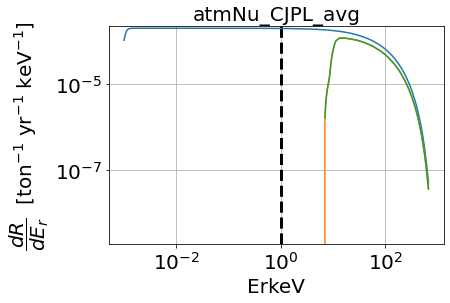

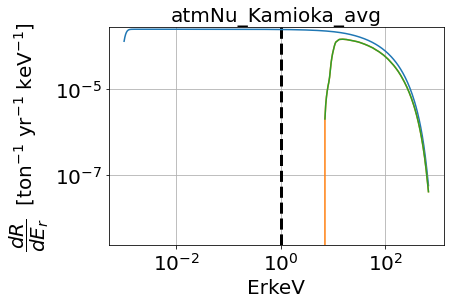

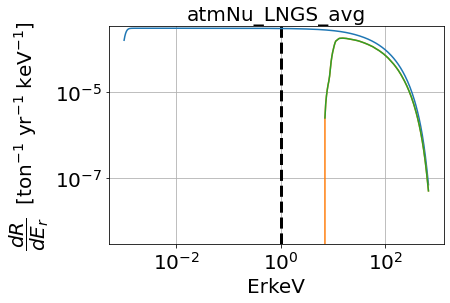

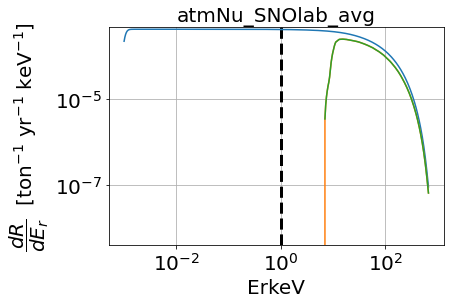

In [8]:
eff_types =['NR_Argon_tot']# ['']#['NR_Xe100_S1S2']
nuclei = 'Argon'
detectors = ['CJPL','Kamioka', 'LNGS', 'SNOlab']#, 'SURF'
metallicity = ''
E_threshold_keV = 1
pcles =['atmNu_'+detector +'_avg' for detector in detectors]# [ 'dsnb']#['pp',  'Be7_384', 'Be7_861', 'pep','CNO']#, ,  'Kr85', 'nubb', 'Rn222'
#[ 'hep', '8B']# [ 'dsnb']#+ 
size = 10000000
write = True
sigma_percentage = 0.1
corr ='_smear'+str(sigma_percentage)


for p, pcle in enumerate(pcles):
    recoil_type = get_recoil_type(pcle)
    bind = get_Ebind(pcle,recoil_type, True)
    for eff_type in eff_types:
        if size < 1e4:
            fig2, ax2 = plt.subplots(1, 2, figsize = (10*2, 5))
        
        Er_keV, pdf  = read_pcle_pdf(pcle, nuclei, eff_type, recoil_type = recoil_type, 
                                     metallicity_model = metallicity, ebinding = True, plot = True, corr = corr)
        
        good = [p>0 and E>=E_threshold_keV for p, E in zip(pdf, Er_keV)]
        valid_Er_keV, valid_pdf = Er_keV[good], pdf[good]
        
        valid_cdf = get_cdf(valid_pdf[:-1]*unit_pdf, np.diff(valid_Er_keV)*unit_Er, 'survival')
        norm = max(get_cdf(valid_pdf[:-1]*unit_pdf, np.diff(valid_Er_keV)*unit_Er, ''))

        plt.loglog(valid_Er_keV, valid_pdf)
        f = interp1d(valid_cdf/norm, valid_Er_keV[:-1], bounds_error=True)
        
        j = 0
        accept_x, accept_y = np.zeros(size), np.zeros(size)
        start = time.time()
        while j < size:
            if j % int(size/100) ==0:
                print(j/size*100, 'percent complete')

        
            try:
                cdf_sim = np.random.uniform() 
                keV = f(cdf_sim)
                
            except ValueError:
                print('valueERROR')
                continue
            
            accept_x[j], accept_y[j] = keV, cdf_sim
            j+=1
            #accept_x[s], accept_y[s] = generate_accept_inputfile(valid_Er_keV, valid_pdf, 
            #                                    min(valid_Er_keV), max(valid_Er_keV), max(valid_pdf)+max(valid_pdf)/10)
        print('--------',time.time() - start,'s---------')
        

        ebind = get_Ebind(pcle,recoil_type, True)
        if corr !='' and pcle not in ['Kr85', 'nubb', 'Rn222' ]:
            file_name = 'Er_'+pcle+ebind+recoil_type+'_'+nuclei+'_'+eff_type+'_'+str(
                size)+'_thrd'+str(
                E_threshold_keV)+'keV_'+metallicity+corr+'.txt'
        else:
            file_name = 'Er_'+pcle+ebind+recoil_type+'_'+nuclei+'_'+eff_type+'_'+str(
                size)+'_thrd'+str(
                E_threshold_keV)+'keV'+corr+'.txt'
        print(file_name)
        file= os.path.join(folder,file_name)
        if write:
            write_file_data(file, np.array([accept_x, accept_y]).T, 10, append= False)
        
        norm = max(get_cdf(valid_pdf[:-1]*unit_pdf, np.diff(valid_Er_keV)*unit_Er, ''))
        print(norm)
        
        if size < 1e4:
            ax2[0].scatter(accept_x,accept_y, color = 'blue', alpha = 0.5)
            ax2[0].loglog(valid_Er_keV, valid_pdf, color = 'black', lw = 3)
            ax2[0] = setup_cdfpdf_ax(ax2[0], pcle + ' '+eff_type+' '+str(norm), 'Er_keV', '', True, 'pdf', 20, 20, 
                        vlines = [E_threshold_keV], hlines = [0], xlims = [0,0], ylims = [max(valid_pdf)/1000,1.1*max(valid_pdf)], log = [1,1])



            ax2[1].hist(accept_x, density = True, alpha = 0.3)
            ax2[1].loglog(valid_Er_keV, valid_pdf*unit_pdf/norm, color = 'black', lw = 3)
            ax2[1] = setup_cdfpdf_ax(ax2[1], pcle + ' '+eff_type+' '+str(norm), 
                        'Er_keV', str((valid_pdf*unit_pdf/norm).unit), True, '', 20, 20, 
                        vlines = [E_threshold_keV], hlines = [0], xlims = [0,0], 
                                     ylims = [max(valid_pdf*unit_pdf/norm).value/100000,1.1*max(valid_pdf*unit_pdf/norm).value], 
                                     log = [1,1])



In [38]:
file_name

'Er_atmNu_SURF_avg_NR_Argon_NR_Argon_tot_10000000_thrd1keV__smear0.1.txt'

In [39]:
'Er_'+pcle+ebind+recoil_type+'_'+nuclei+'_'+eff_type+'_'+str(
                size)+'_thrd'+str(
                E_threshold_keV)+'keV'+corr+'.txt'

'Er_atmNu_SURF_avg_NR_Argon_NR_Argon_tot_10000000_thrd1keV_smear0.1.txt'